## Prepared

In [37]:
# Import Libraries for Data Manipulation
import pandas as pd
import numpy as np
from collections import defaultdict

# Import Libraries for Data Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Import Libraries for Database Handling
import sqlite3
import pickle

# Import Libraries for TensorFlow/Keras-based Deep Learning Model Building
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import layers, optimizers, Sequential, backend as K
from tensorflow.keras.preprocessing.text import tokenizer_from_json
from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, SimpleRNN, Activation, Flatten
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from keras.models import load_model
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, SimpleRNN, Activation
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras.layers import Flatten
from tensorflow.keras import backend as K
from tensorflow import keras
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l1
from tensorflow.keras.regularizers import l2
from tensorflow.keras.regularizers import L1L2


# Import Libraries for Machine Learning Model Evaluation and Cross Validation
from sklearn.model_selection import train_test_split, KFold
from sklearn import metrics
from sklearn.metrics import classification_report, accuracy_score

# Import Regex Library for Text Preprocessing
import re
import io
import json

# -------------------------------------------------------------------
# Penjelasan fungsi utama pustaka yang digunakan:
# - `pandas`, `numpy`: Digunakan untuk manipulasi data dan komputasi numerik.
# - `seaborn`, `matplotlib`: Untuk visualisasi data.
# - `tensorflow.keras`, `keras`: Untuk membangun, melatih, dan mengevaluasi model deep learning.
# - `sklearn`: Untuk evaluasi kinerja model dan pembagian data (train-test split, KFold cross validation).
# - `re`: Untuk preprocessing data teks (misalnya, menghapus karakter tidak diinginkan).
# - `sqlite3`, `pickle`: Untuk pengelolaan basis data dan penyimpanan model.
# -------------------------------------------------------------------


In [130]:
## Call the Database

In [2]:
# Establish a connection to the SQLite database
db_path = r'E:\Sentimen\sentimen\data.db'
connection = sqlite3.connect(db_path, check_same_thread=False)

# Define SQL query to retrieve data from 'a_train' table
sql_query = 'SELECT * FROM a_trainb'

# Execute the query and load data into a DataFrame
a_train_data = pd.read_sql(sql_query, connection)

# Display the first few rows of the retrieved data
a_train_data.head()


,Teks,Label
0,warung dimiliki pengusaha pabrik tahu puluhan ...,positive
1,mohon ulama lurus mmbri hujjah partai diwlh su...,neutral
2,lokasi strategis jalan sumatra bandung nyaman ...,positive
3,betapa bahagia unboxing paket barang bagus men...,positive
4,aduh mahasiswa jangan sombong dong kasih kartu...,negative


In [132]:
# Check Yow

In [3]:
# Menghitung jumlah kemunculan masing-masing nilai di kolom 'label'
label_counts = a_train_data['Label'].value_counts()

# Menampilkan nilai frekuensi masing-masing kategori
print(label_counts)

# Menghitung total jumlah data
total_count = label_counts.sum()

# Menampilkan total jumlah data
print(f"Total count: {total_count}")

Label
positive    6416
negative    3436
neutral     1148
Name: count, dtype: int64
Total count: 11000


## LETS FIX IT

In [9]:
category = pd.get_dummies(a_train_data.Label)
atb = pd.concat([a_train_data, category], axis=1)
atb = atb.drop(columns='Label')
# atb di column ke label

In [7]:
x = atb['Teks'].values
y = atb[['negative', 'neutral', 'positive']].values

In [11]:
y

array([[False, False,  True],
       [False,  True, False],
       [False, False,  True],
       ...,
       [False,  True, False],
       [ True, False, False],
       [False, False,  True]])

In [12]:
tokenizer = Tokenizer(num_words=5000, oov_token='x')
tokenizer.fit_on_texts(x)
seks_x = tokenizer.texts_to_sequences(x)
paddeds_x = pad_sequences(seks_x) 

In [14]:
x_train, x_test, y_train, y_test = train_test_split(paddeds_x, y, test_size=0.2, random_state = 42)

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state = 42)

In [26]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=5000, output_dim=64),
    
    tf.keras.layers.LSTM(64),
        
    tf.keras.layers.Dense(64, kernel_regularizer=L1L2(l1=0.01, l2=0.01), activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.BatchNormalization(),
    
    tf.keras.layers.Dense(64, kernel_regularizer=L1L2(l1=0, l2=0.01), activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.BatchNormalization(),
    
    tf.keras.layers.Dense(64, kernel_regularizer=L1L2(l1=0, l2=0.01), activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.BatchNormalization(),
    
    tf.keras.layers.Dense(64, kernel_regularizer=L1L2(l1=0, l2=0.01), activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.BatchNormalization(),
    
    tf.keras.layers.Dense(64, kernel_regularizer=L1L2(l1=0, l2=0.01), activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.BatchNormalization(),    
    
    tf.keras.layers.Dense(3, activation='softmax')
])

In [28]:
import time

# Mulai pengukuran waktu
start_time = time.time()

# Definisikan callback dan kompilasi model
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('val_categorical_accuracy') > 0.85 ):
            self.model.stop_training = True

callbacks = myCallback()
adam = optimizers.Adam(learning_rate = 0.001)
model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['categorical_accuracy'])

# Melatih model
num_epochs = 8
fit = model.fit(x_train, 
                y_train, 
                 batch_size = 16,
                epochs=num_epochs, 
                validation_data=(x_val, y_val),
                 validation_split=0.2,       
                callbacks = [callbacks]
)

# Selesai pengukuran waktu
end_time = time.time()

# Cetak waktu yang dibutuhkan
print("Waktu yang dibutuhkan untuk pelatihan: {:.2f} detik".format(end_time - start_time))


Epoch 1/8
440/440 ━━━━━━━━━━━━━━━━━━━━ 14s 17ms/step - categorical_accuracy: 0.5630 - loss: 7.4293 - val_categorical_accuracy: 0.7693 - val_loss: 3.7440
Epoch 2/8
440/440 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - categorical_accuracy: 0.7651 - loss: 2.9554 - val_categorical_accuracy: 0.7977 - val_loss: 1.6568
Epoch 3/8
440/440 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - categorical_accuracy: 0.8425 - loss: 1.3580 - val_categorical_accuracy: 0.8165 - val_loss: 0.9894
Epoch 4/8
440/440 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - categorical_accuracy: 0.8809 - loss: 0.8002 - val_categorical_accuracy: 0.8392 - val_loss: 0.7105
Epoch 5/8
440/440 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - categorical_accuracy: 0.9014 - loss: 0.5494 - val_categorical_accuracy: 0.8386 - val_loss: 0.7075
Epoch 6/8
440/440 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - categorical_accuracy: 0.9204 - loss: 0.3970 - val_categorical_accuracy: 0.8307 - val_loss: 0.6245
Epoch 7/8
440/440 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - categorical_accuracy: 0.9376 - l

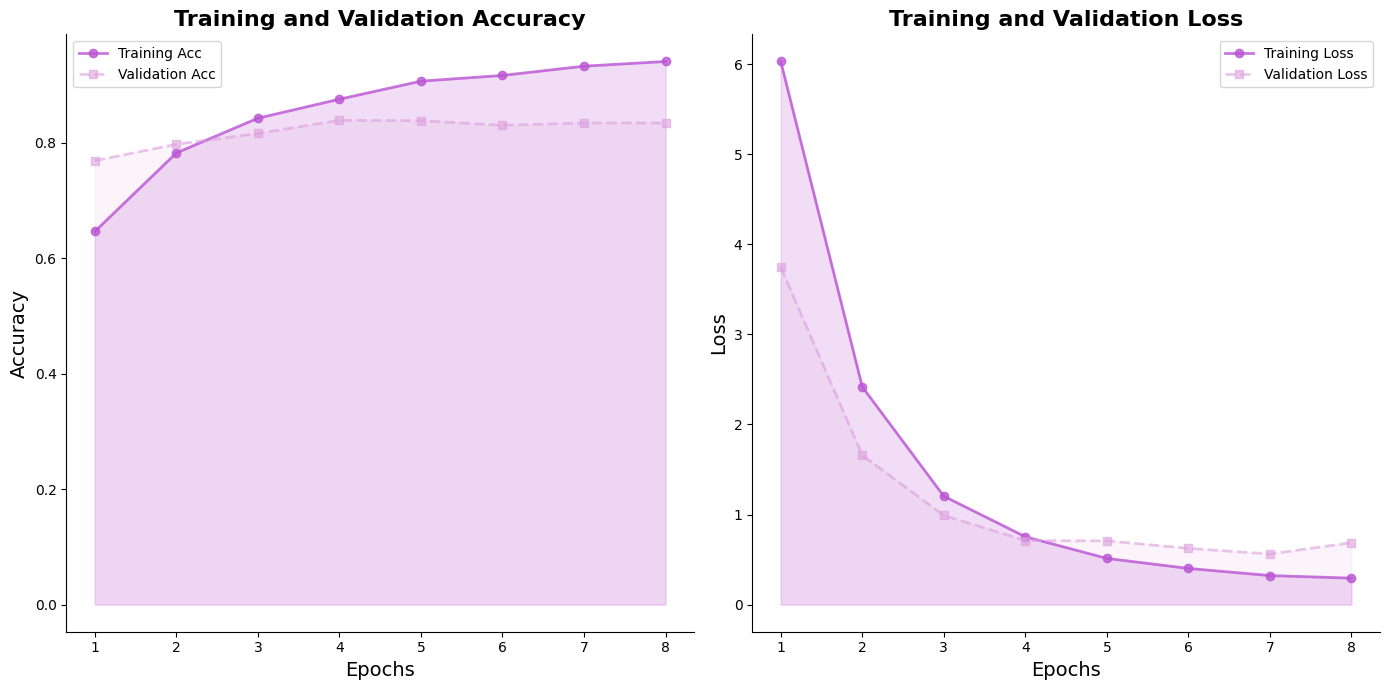

In [29]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

def plot_history(fit):
    acc = fit.history['categorical_accuracy']
    val_acc = fit.history['val_categorical_accuracy']
    loss = fit.history['loss']
    val_loss = fit.history['val_loss']
    epochs = np.array(range(1, len(acc) + 1))

    plt.figure(figsize=(14, 7))

    # Plot Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, color='mediumorchid', alpha=0.8, linewidth=2, marker='o', markersize=6, linestyle='-', label='Training Acc')
    plt.plot(epochs, val_acc, color='plum', alpha=0.6, linewidth=2, marker='s', markersize=6, linestyle='--', label='Validation Acc')
    plt.fill_between(epochs, acc, color='mediumorchid', alpha=0.2)
    plt.fill_between(epochs, val_acc, color='plum', alpha=0.1)
    plt.title('Training and Validation Accuracy', fontsize=16, fontweight='bold', family='sans-serif')
    plt.xlabel('Epochs', fontsize=14)
    plt.ylabel('Accuracy', fontsize=14)
    plt.legend()
    sns.despine()

    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, color='mediumorchid', alpha=0.8, linewidth=2, marker='o', markersize=6, linestyle='-', label='Training Loss')
    plt.plot(epochs, val_loss, color='plum', alpha=0.6, linewidth=2, marker='s', markersize=6, linestyle='--', label='Validation Loss')
    plt.fill_between(epochs, loss, color='mediumorchid', alpha=0.2)
    plt.fill_between(epochs, val_loss, color='plum', alpha=0.1)
    plt.title('Training and Validation Loss', fontsize=16, fontweight='bold', family='sans-serif')
    plt.xlabel('Epochs', fontsize=14)
    plt.ylabel('Loss', fontsize=14)
    plt.legend()
    sns.despine()

    plt.tight_layout()
    plt.show()

# Memanggil fungsi plot_history untuk memvisualisasikan hasil
plot_history(fit)


In [30]:
train_loss, train_acc = model.evaluate(x_train, y_train, steps=16)
val_loss, val_acc = model.evaluate(x_val, y_val, steps=16)
test_loss, test_acc = model.evaluate(x_test, y_test, steps=16)

print('\nTrain: %.3f, val: %.3f, test: %.3f,' % (train_acc, val_acc, test_acc))

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - categorical_accuracy: 0.9681 - loss: 0.1880
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - categorical_accuracy: 0.8394 - loss: 0.6993
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - categorical_accuracy: 0.8247 - loss: 0.7206

Train: 0.969, val: 0.835, test: 0.817,


In [32]:
filename = 'lstmbackup.keras'
model.save(filename)

In [35]:
tokenizer_json = tokenizer.to_json()
with io.open('tokenizer_lstm.json', 'w', encoding='utf-8') as f:
    f.write(json.dumps(tokenizer_json, ensure_ascii=False))

In [44]:
from tensorflow.keras.models import load_model

with open('tokenizer_lstm.json') as f:
    data = json.load(f)
    tokenizer = tokenizer_from_json(data)
loaded_model = load_model(r'lstm.h5')

In [62]:
import re
import pandas as pd
import sqlite3
import json
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import tokenizer_from_json
from tensorflow.keras.models import load_model

# Menghubungkan ke database SQLite
db_path = r'E:\Sentimen\sentimen\data.db'
connection = sqlite3.connect(db_path)

# Fungsi membersihkan teks
def clean_text(text):
    text = re.sub(r'((www\.[^\s]+)|(https?://[^\s]+)|(http?://[^\s]+))', '', text)  # Hapus URL dan tautan
    text = re.sub(r'pic.twitter.com\.\w+', '', text)
    text = re.sub(r'[^a-z\s]', ' ', text.lower())  # Hapus karakter yang tidak diinginkan, termasuk angka
    text = text.replace('user', '')  # Hapus kata 'user'
    text = re.sub(' +', ' ', text)  # Hapus spasi berlebih
    text = text.replace('\n', ' ')  # Hapus karakter \n (newline)
    return text.strip()

# Fungsi standarisasi teks (ganti teks alay dengan baku)
def standardize_text(text):
    alay_df = pd.read_sql_query('SELECT * FROM kamus_alay', connection)
    alay_dict = dict(zip(alay_df['alay'], alay_df['fix']))  # Buat kamus dari teks alay ke baku
    words = text.split()
    standardized_words = [alay_dict.get(word, word) for word in words]  # Ganti teks alay dengan baku
    return ' '.join(standardized_words).strip()

# Fungsi hapus stopwords
def remove_stopwords(text):
    stopword_query = 'SELECT * FROM stopword'
    stopword_df = pd.read_sql_query(stopword_query, connection)
    stopwords = set(stopword_df['stop'])
    words = text.split()
    filtered_words = [word for word in words if word not in stopwords]
    return ' '.join(filtered_words)

# Fungsi untuk melakukan preprocessing teks input dan mengembalikan teks asli dan yang sudah dibersihkan
def preprocess_input(text):
    original_text = text  # Simpan teks asli
    text = clean_text(text)
    text = standardize_text(text)
    # Jika ingin menghapus stopwords, uncomment ini
    # text = remove_stopwords(text)
    cleaned_text = text  # Simpan teks yang telah dibersihkan
    return original_text, cleaned_text

# Fungsi prediksi
def pred_sentiment(text, model, tokenizer):
    # Preprocessing teks
    original_text, cleaned_text = preprocess_input(text)
    
    # Tampilkan teks asli dan hasil cleaning
    print(f"Teks Asli: {original_text}")
    print(f"Teks Setelah Cleaning: {cleaned_text}")
    
    # Mengubah teks menjadi sequences dan melakukan padding
    sequences = tokenizer.texts_to_sequences([cleaned_text])
    padded_sequences = pad_sequences(sequences, maxlen=100)  # Sesuaikan maxlen dengan model

    # Melakukan prediksi
    predictions = model.predict(padded_sequences)

    return predictions[0]

# Fungsi untuk menampilkan hasil prediksi
def pred(predictions):
    labels = ['Negatif', 'Netral', 'Positif']
    predicted_label = labels[predictions.argmax()]
    print(f"Prediksi Sentimen: {predicted_label}")
    return predicted_label

# Muat model dan tokenizer
with open('tokenizer_lstm.json') as f:
    data = json.load(f)
    tokenizer = tokenizer_from_json(data)

loaded_model = load_model(r'lstm.h5')

# Contoh teks input
input_text = "idih si embul durjana"

# Lakukan prediksi
predictions = pred_sentiment(input_text, loaded_model, tokenizer)

# Tampilkan hasil prediksi
pred(predictions)


Teks Asli: idih si embul durjana
Teks Setelah Cleaning: idih sih embul durjana
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step
Prediksi Sentimen: Negatif


'Negatif'